# Neural Network Regression

The data here contains the information from 1990 California census. Thus, this dataset doesn't include any current housing prices, but it still can be used to benchmark different models. One important prior step is to clean the data which was done in data_preprocessing.py.

More inforamtion can be found here: [https://www.kaggle.com/code/antoniofurioso/california-housing-prediction](https://www.kaggle.com/code/antoniofurioso/california-housing-prediction)

In [1]:
# Load Environments:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error)
import copy
# import math
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

## Load Data

In [2]:
class Load_Dataset(Dataset):
    def __init__(self, path_, file_):
        """
        Constructor for the class Load_Dataset
        
        Parameters are:
        path ... Path (str) to the directory containing the data file.
        file ... Name of the data file (str).
        test_size ... Percentage of test and training data given as a float
        random_state ... Random Number Generator needs a seed
        """
        self.path = path_
        self.file = file_

        self.load_data_()

    def load_data_(self):
        # Exception handling to check whether the file exists for a given path! Otherwise raise an error!
        file_path = os.path.join(self.path, self.file)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File '{self.file}' not found in directory '{self.path}'.")

        # Read data from the CSV file
        self.df_table = pd.read_csv(file_path)
        self.df_header = self.df_table.columns.tolist()
        
        # Give the data already back as a torch tensor:
        self.data_table = torch.tensor(pd.read_csv(file_path, header=0, dtype=np.float32).values, dtype=torch.float32)

## Neural Network Architecture

In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dim = input_dim
        # Number of output dimensions m
        self.output_dim = output_dim
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.hidden_layers = hidden_layers
        # Activation function
        self.activation=nn.ReLU()
        self.output_activation=nn.Sigmoid()

        self.input_layer = nn.Linear(self.input_dim, self.neurons)
        # List with all Hidden Layers:
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(self.hidden_layers - 1)])

        # Output Layer:
        self.output_layer = nn.Linear(self.neurons, self.output_dim)

    def forward(self, x):
        # Setup for MLP (Multilayer Perceptron)
        # First: fully conncected neural network:
        x = self.activation(self.input_layer(x))

        # Feed forward through all hidden layers:
        for _, layer in enumerate(self.hidden_layers):
            x = self.activation(layer(x))

        # Feed forward to the output Layer:
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x

## Training

In [4]:
class Reg_Trainer:
    def __init__(self, 
                 dataset_path_ = '/home/yannick/ETH_Zurich/AISE/Project_1/Task3/Data/',
                 train_ds_name_ = 'train_ds.csv',
                 test_ds_name_ = 'test_ds.csv'
                 ):

        # Dataset with the Test and Train Data:
        self.dataset_path = dataset_path_
        self.train_ds_name = train_ds_name_
        self.test_ds_name = test_ds_name_
        
        self.train_ds = Load_Dataset(self.dataset_path, self.train_ds_name)
        self.test_ds = Load_Dataset(self.dataset_path, self.test_ds_name)

        # The header are required for the dataset assembling using DataLoader!
        self.header_tot = self.train_ds.df_header
        # For the input dataset delete the target feature
        self.header_inp = copy.deepcopy(self.header_tot)
        self.header_inp.remove('median_house_value')

        # index of the target feature:
        self.idx_target_f = self.header_tot.index('median_house_value')

        # NOTE: that I drop the target value, since this should be predicted and is the output!
        self.input_dim = self.train_ds.data_table.shape[1] - 1
        self.output_dim = 1 # length of target features is 1!
        self.hidden_layers = 4
        self.neurons = self.input_dim * 2

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.regression = NeuralNet(self.input_dim, self.output_dim, self.hidden_layers, self.neurons).to(self.device)

        # Loss Function:
        self.loss_mse = nn.MSELoss() # default behaviour is the mean

        # For the scaling and normalization of the output we just use the following:
        self.scaler = MinMaxScaler()
        self.dataset_train, self.dataset_test = (self.assemble_datasets())

        # Optimizer used (ADAM) or SGD could also be considered
        self.optimizer = optim.Adam(self.regression.parameters())

    # The input features typically should be normalized to be between 0 and 1 for better results
    # but here instead we use the normalization for the output data since the sigmoid function sets the output
    # between 0 and 1!
    def normalization(self, tens):
        return self.scaler.fit_transform(tens)

    # Undo the normalization!
    def inverse_normalization(self, tens):
        return self.scaler.inverse_transform(tens)

    def assemble_datasets(self):
        # Total input with the target feature!
        train_inp_tot = self.train_ds.data_table
        test_inp_tot = self.test_ds.data_table

        # Delete the target feature row from the input
        train_inp = torch.cat((train_inp_tot[:,:self.idx_target_f], train_inp_tot[:,self.idx_target_f+1:]), dim = 1)
        test_inp = torch.cat((test_inp_tot[:,:self.idx_target_f], test_inp_tot[:,self.idx_target_f+1:]), dim = 1)

        # Output should be the target feature row
        train_out = train_inp_tot[:, self.idx_target_f]
        test_out = test_inp_tot[:, self.idx_target_f]
  
        # Normalize the output data
        train_out_normalized = torch.tensor(self.normalization(train_out.numpy().reshape(-1, 1)))
        test_out_normalized = torch.tensor(self.normalization(test_out.numpy().reshape(-1, 1)))

        training_set = DataLoader(
            torch.utils.data.TensorDataset(train_inp, train_out_normalized),
            batch_size=150, shuffle=True, pin_memory=True)
        
        test_set = DataLoader(
            torch.utils.data.TensorDataset(test_inp, test_out_normalized),
            batch_size=150, shuffle=True, pin_memory=True)
        
        return training_set, test_set
    
    def compute_loss(self, inp, true_out, verbose=False):
        # Get the posterior:
        approx_out = self.regression(inp)

        # Inverse Normalization Transformation:
        # true_out_scaled = torch.tensor(self.inverse_normalization(true_out.numpy().reshape(-1,1)))
        # approx_out_scaled = torch.tensor(self.inverse_normalization(approx_out.numpy().reshape(-1,1)))

        true_out_scaled = torch.tensor(self.inverse_normalization(true_out.detach().numpy().reshape(-1,1)))
        approx_out_scaled = torch.tensor(self.inverse_normalization(approx_out.detach().numpy().reshape(-1,1)))

        # Compute the loss
        loss_normalized = self.loss_mse(approx_out, true_out) # MSE
        loss_scaled = torch.sqrt(self.loss_mse(approx_out_scaled, true_out_scaled)) # RMSE

        if verbose:
           print(
               "Normalized MSE loss: ",round(loss_normalized.item(), 4),
               "| Scaled RMSE Loss: ", round(loss_scaled.item(), 4)
          )
        # Only the normalized loss is relevant for training!
        return loss_normalized, loss_scaled
    
    def fit(self, num_epochs, verbose=True):
        history = list()
        history_scaled = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for inp_train, u_train in self.dataset_train:
                def closure():
                    self.optimizer.zero_grad()
                    loss, loss_scaled = self.compute_loss(inp_train.to(self.device), u_train.to(self.device), verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    history_scaled.append(loss_scaled.item())
                    return loss

                self.optimizer.step(closure=closure)

        print('Final Loss Normalized: ', history[-1])
        print('Final Loss Scaled: ', history_scaled[-1])

        return history, history_scaled
    

    def validation(self):
        # Cross Validation or other techniques can be used here to benchmark the training!
        prediction = []
        val_output = []
        with torch.no_grad():
            for data in self.dataset_test:
                inputs, targets = data
                approx = self.regression(inputs)

                prediction.extend(approx.numpy())
                val_output.extend(targets.numpy())

        # prediction = prediction.reshape(-1,1)
        # val_output = val_output.reshape(-1,1)

        prediction = np.array(prediction).reshape(-1, 1) 
        val_output = np.array(val_output).reshape(-1, 1) 

        prediction_scaled = self.inverse_normalization(prediction)
        val_output_scaled = self.inverse_normalization(val_output)

        # Since we need the RMSE which was done in the Kaggle webpage I will also use this one for comparison:
        # Normalized MSE and RMSE
        mse_normalized = mean_squared_error(val_output, prediction)
        rmse_normalized = root_mean_squared_error(val_output, prediction)

        # Scaled MSE and RMSE
        mse_scaled = mean_squared_error(val_output_scaled, prediction_scaled)
        rmse_scaled = root_mean_squared_error(val_output_scaled, prediction_scaled)

        print("Normalized MSE:    ", round(mse_normalized, 4))
        print("Normalized RMSE:    ", round(rmse_normalized, 4))

        print("Scaled MSE:    ", round(mse_scaled, 4))
        print("Scaled RMSE:    ", round(rmse_scaled, 4))

    

    

## Data Analysis and Preprocessing

In [5]:
num_epochs = 200
reg = Reg_Trainer()

hist, hist_scaled = reg.fit(num_epochs)


################################  0  ################################
Normalized MSE loss:  0.0725 | Scaled RMSE Loss:  128541.8672
Normalized MSE loss:  0.0709 | Scaled RMSE Loss:  127104.8906
Normalized MSE loss:  0.0622 | Scaled RMSE Loss:  119112.8828
Normalized MSE loss:  0.0601 | Scaled RMSE Loss:  117060.8438
Normalized MSE loss:  0.0699 | Scaled RMSE Loss:  126265.875
Normalized MSE loss:  0.0683 | Scaled RMSE Loss:  124797.7812
Normalized MSE loss:  0.0633 | Scaled RMSE Loss:  120173.9219
Normalized MSE loss:  0.0648 | Scaled RMSE Loss:  121505.3594
Normalized MSE loss:  0.0626 | Scaled RMSE Loss:  119439.8359
Normalized MSE loss:  0.0752 | Scaled RMSE Loss:  130928.8828
Normalized MSE loss:  0.0612 | Scaled RMSE Loss:  118174.75
Normalized MSE loss:  0.0698 | Scaled RMSE Loss:  126138.2188
Normalized MSE loss:  0.0598 | Scaled RMSE Loss:  116758.2734
Normalized MSE loss:  0.0674 | Scaled RMSE Loss:  123979.4766
Normalized MSE loss:  0.0584 | Scaled RMSE Loss:  115355.1328
Nor

## Validation and Plotting of the Loss Function

Normalized MSE:     0.0126
Normalized RMSE:     0.1124
Scaled MSE:     2880705300.0
Scaled RMSE:     53672.203


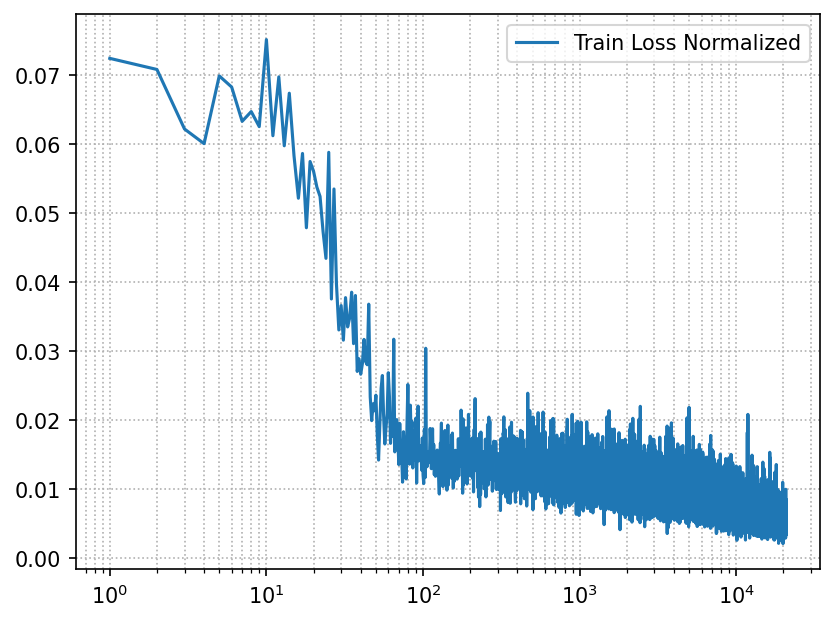

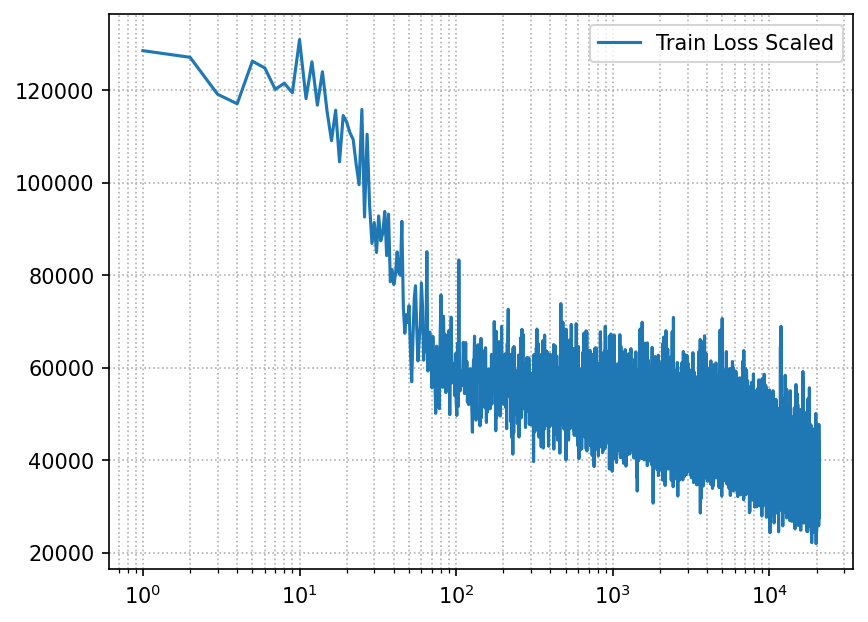

In [6]:
reg.validation()

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss Normalized")
plt.xscale("log")
plt.legend()
plt.savefig('loss_normalized.png')

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist_scaled, label="Train Loss Scaled")
plt.xscale("log")
plt.legend()
plt.savefig('loss_scaled.png')